# Data exploration of NYCPD 

In [1]:
#!pip install pysal
#!pip install contextily
#!pip install geopandas
#!pip uninstall pyproj -y    #### Only if geopandas is irritating
#pip install pyproj


In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd 
import seaborn as sns 
import scipy
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing 
from sklearn.pipeline import make_pipeline 


In [2]:
from sklearn import cluster
from pysal.lib import weights 
from pysal.lib import examples

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import esda
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights
from libpysal.weights import block_weights
import shapely.geometry as geom
from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed
from pointpats import distance_statistics





### Notes about the COMPAS and data 
- COMPAS
    - Recidivism: We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored
    - For violent recidivism, we used the FBI’s definition of violent crime, a category that includes murder, manslaughter, forcible rape, robbery and aggravated assault.
        - Model 1: Logistic Regression on To test racial disparities in the score controlling for other factors, we created a logistic regression model that considered race, age, criminal history, future recidivism, charge degree, gender and age.
        - Model 2: To test COMPAS’s overall predictive accuracy, we fit a Cox proportional hazards model to the data – the same technique that Northpointe used in its own validation study. A Cox model allows us to compare rates of recidivism while controlling for time. Because we aren’t controlling for other factors such as a defendant’s criminality we can include more people in this Cox model. 
    
- Data at hand:
    - Arrast_key: Randomly generated persistent ID for each arrest 
    - Arrest date: Exact date of arrest for the reported event
    - PD_CD: Three digit internal classification code (more granular than Key Code)
    - PD_DESC: Description of internal classification corresponding with PD code (more granular than Offense Description)
    - KY_PD: Three digit internal classification code (more general category than PD code)
    - OFNS_DESC: Description of internal classification corresponding with KY code (more general category than PD description)
    - Law_Code: Law code charges corresponding to the NYS Penal Law, VTL and other various local laws
    - Law_cat_cd: Level of offense: felony, misdemeanor, violation
    - Arrest_boro: Borough of arrest. B(Bronx), S(Staten Island), K(Brooklyn), M(Manhattan), Q(Queens)
    - Arrest_precint: Precinct where the arrest occurred
    - Jurisdiction_code: Jurisdiction responsible for arrest. Jurisdiction codes 0(Patrol), 1(Transit) and 2(Housing) represent NYPD whilst codes 3 and more represent non NYPD jurisdictions
    - Age_group: Perpetrator’s age within a category
    - perp_sex: Perpetrator’s sex description
    - Perp_race: Perpetrator’s race description
    - X_coord_CD: Midblock X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)
    - Y_coord_CD: Midblock Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)
    - Latitude: Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)
    - Longitude: Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)
    

#### Notes from Anders 
 1) Model of Recidivism
 2) Label in the Data???
 3) Quantify: Log-odds, parity and  
 4) Ethics: We want to investiagte Polcie use of arrests. Are they targeting specific crimes which are Minority discrimnary?, We will compare Police juriscrition areas with one another 
    Duty ethics (deontology)
 5) use Geometric Di-biasing 



In [3]:
## Takes 
df_arrest_2024 = pd.read_csv(r"uip8-fykc_version_160.csv") ### Arrest History 2024    ### https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc/about_data
df_arrest_historic = pd.read_csv(r"NYPD_Arrests_Data__Historic__20240509.csv") ### Arrest History  ### https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u/about_data
df_Complaint_2024 = pd.read_csv(r"NYPD_Complaint_data_Current__Year_To_Date__20240509.csv") ### Complaints ### url https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data
#df_Recidivism = pd.read_csv(r"Recidivism__Beginning_2008_20240509.csv") ### Not important 
#### Read shapefiles 
Police_Pricints = gpd.read_file(r"geo_export_796837b0-d745-4c86-9276-ecea1faf2a8a.shp") ### Police Pricints ### https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz



#df_columns = df.columns

C:\Users\User\AppData\Local\Temp\ipykernel_14608\1286271519.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Complaint_2024 = pd.read_csv(r"NYPD_Complaint_data_Current__Year_To_Date__20240509.csv") ### Complaints ### url https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data


In [4]:
#df_arrest_historic

In [5]:
gdf_arrest_2024 = gpd.GeoDataFrame(df_arrest_2024, geometry=gpd.points_from_xy(df_arrest_2024.longitude, df_arrest_2024.latitude), crs = "EPSG:4326")

In [6]:
#### Read shapefiles 
Police_Precints = gpd.read_file(r"geo_export_796837b0-d745-4c86-9276-ecea1faf2a8a.shp")


#Police_Pricints.plot()
#plt.title("Police Precints")
Police_Precints_names = ["1st Precinct", "5th Precint", "6th Precint", "7th Precint", "9th Precint", "10th Precint", "13th Precint", "Midtown South Precint", "17th Precint", 
                         "Midtown South Precint",""]


Police_Precints

,precinct,shape_area,shape_leng,geometry
0,1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,5.0,1.809453e+07,18807.124911,"POLYGON ((-73.98864 40.72293, -73.98869 40.722..."
2,6.0,2.214302e+07,27255.991120,"POLYGON ((-74.00915 40.74251, -74.00895 40.742..."
3,7.0,1.836667e+07,17287.544493,"POLYGON ((-73.97346 40.71896, -73.97357 40.718..."
4,9.0,2.139539e+07,19772.510741,"POLYGON ((-73.97161 40.72672, -73.97163 40.726..."
...,...,...,...,...
72,115.0,1.141197e+08,60059.410758,"POLYGON ((-73.85892 40.76241, -73.85931 40.762..."
73,120.0,2.323280e+08,92945.697403,"POLYGON ((-74.05357 40.60370, -74.05407 40.603..."
74,121.0,4.755776e+08,136811.464647,"MULTIPOLYGON (((-74.15946 40.64145, -74.15975 ..."
75,122.0,4.548521e+08,154842.385071,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."


In [7]:
merged_gdf = gpd.sjoin(gdf_arrest_2024, Police_Precints, how='right', predicate='within')

#merged_gdf = gpd.sjoin(gdf_arrest_2024, Police_Pricints, how='right', predicate='within')
merged_gdf = merged_gdf.reset_index()
new_merged_gdf = merged_gdf.copy()

crimes = merged_gdf[merged_gdf["law_cat_cd"].isin(["M" ,"F"])]
crimes

C:\Users\User\AppData\Local\Temp\ipykernel_14608\2912269482.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  merged_gdf = gpd.sjoin(gdf_arrest_2024, Police_Precints, how='right', predicate='within')


,index,index_left,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,...,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column,precinct,shape_area,shape_leng,geometry
0,0,53869,280981409,2024-01-23T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,WHITE,980210,194782,40.701310,-74.014570,POINT (-74.01457 40.70131),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,0,45583,281029902,2024-01-24T00:00:00.000,511.0,"CONTROLLED SUBSTANCE, POSSESSI",235.0,DANGEROUS DRUGS,PL 2200300,M,...,WHITE HISPANIC,980770,194854,40.701505,-74.012551,POINT (-74.01255073642797 40.701505261974),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
2,0,28122,283104116,2024-03-03T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,WHITE,980770,194854,40.701505,-74.012551,POINT (-74.01255073642797 40.701505261974),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
4,0,24709,282805064,2024-02-26T00:00:00.000,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,...,BLACK,980770,194854,40.701505,-74.012551,POINT (-74.01255073642797 40.701505261974),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
5,0,773,284365468,2024-03-26T00:00:00.000,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 140100G,M,...,WHITE HISPANIC,980770,194854,40.701505,-74.012551,POINT (-74.01255073642797 40.701505261974),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63610,76,31029,282397465,2024-02-18T00:00:00.000,793.0,WEAPONS POSSESSION 3,118.0,DANGEROUS WEAPONS,PL 2650201,F,...,WHITE,933498,144013,40.561813,-74.182656,POINT (-74.18265618342167 40.561812954703754),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560..."
63611,76,46462,282408151,2024-02-18T00:00:00.000,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601002,F,...,WHITE,934356,144153,40.562204,-74.179569,POINT (-74.179569 40.562204),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560..."
63612,76,22541,283309464,2024-03-06T00:00:00.000,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,...,BLACK,933146,144362,40.562769,-74.183925,POINT (-74.183925 40.562769),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560..."
63613,76,32122,283312461,2024-03-06T00:00:00.000,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,...,BLACK,933146,144362,40.562769,-74.183925,POINT (-74.183925 40.562769),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560..."


In [8]:
# index columns is the Polygons index
# index-Left is the arrests index
# Important: Geometry is Prencints so if plot then it gives Prencints plots 



<Axes: >

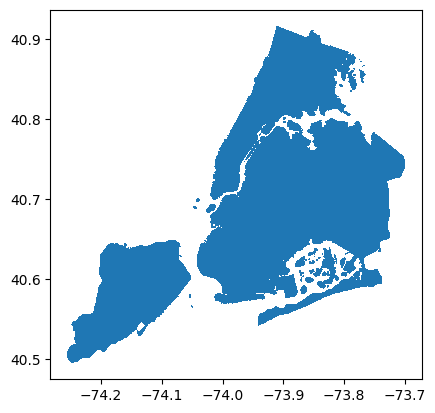

In [9]:
merged_gdf.plot()

In [10]:


merged_gdf
#dd = merged_gdf[merged_gdf["ofns_desc"] == "DANGEROUS DRUGS"]
merged_gdf_new = crimes.copy()
merged_gdf_new['geocoded_column'] = [geom.Point(xy) for xy in zip(merged_gdf_new['longitude'], merged_gdf_new['latitude'])]
print(merged_gdf_new['geocoded_column'].isnull().sum())
merged_gdf_new = merged_gdf_new.set_geometry('geocoded_column')
#merged_gdf_new_sub = merged_gdf_new.sample(10000, random_state=12345) # 10000 is okay. 

0


In [11]:
#merged_gdf_new_sub.head()

C:\Users\User\AppData\Local\Temp\ipykernel_14608\3646044094.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


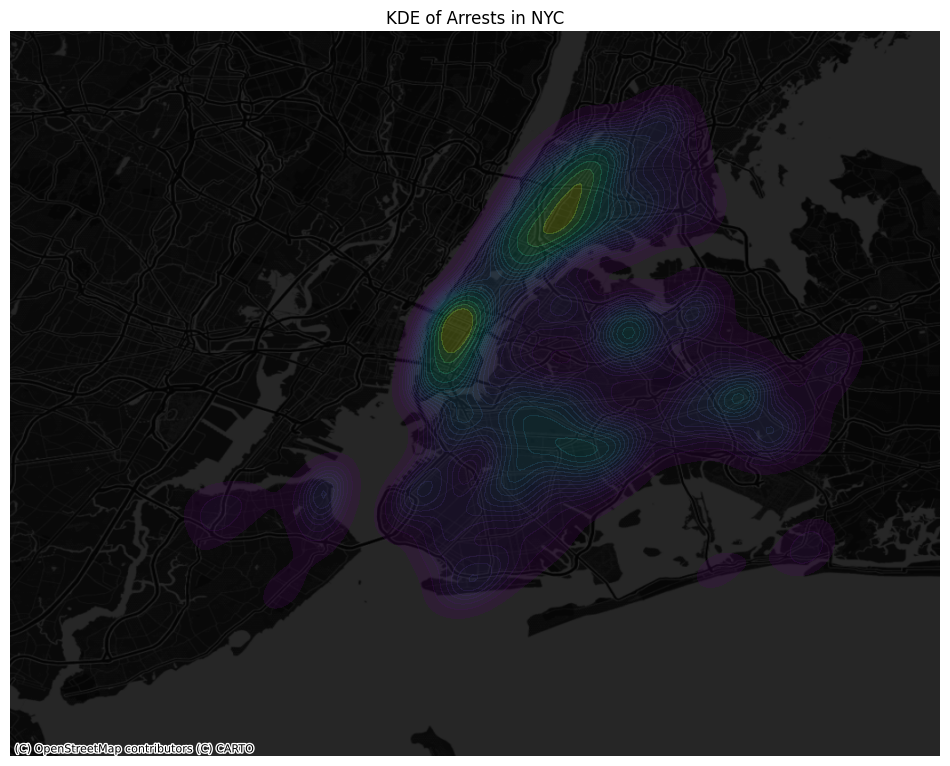

In [12]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add KDE layer that displays probability surface
sns.kdeplot(
    x=merged_gdf_new["longitude"], 
    y=merged_gdf_new["latitude"], 
    n_levels=20, 
    shade=True,
    alpha=0.25,
    cmap="viridis"
)
# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("KDE of Arrests in NYC")
# Draw map
plt.show()

In [13]:
import pyproj

In [14]:
wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 coordinate system
web_mercator = pyproj.CRS('EPSG:3857')  # Web Mercator coordinate system

# Define the transformation function
transformer = pyproj.Transformer.from_crs(wgs84, web_mercator, always_xy=True)

# Define the longitude and latitude coordinates
longitude = 139.791541
latitude = 35.721900

x_list = []
y_list = []
for longitude, latitude in  merged_gdf_new[["longitude","latitude"]].values: 

# Perform the coordinate transformation
    x, y = transformer.transform(longitude, latitude)
    x_list.append(x)
    y_list.append(y)

# Print the converted x and y coordinates
merged_gdf_new["x"] = x_list
merged_gdf_new["y"] = y_list


In [21]:
coordinates_nyc = merged_gdf_new[["x","y"]].values
print(coordinates_nyc)

[[-8239264.2436831   4968384.28391754]
 [-8239039.46029049  4968412.95551546]
 [-8239039.46029049  4968412.95551546]
 ...
 [-8258116.7560464   4948062.53541377]
 [-8258116.7560464   4948062.53541377]
 [-8258489.43045066  4948251.16302925]]


In [16]:

g_test = distance_statistics.g_test(
    coordinates_nyc, support=40, keep_simulatio
    
    ns=True, n_simulations=999
)

In [17]:
#g_test

In [18]:
np.median(g_test.simulations)

1.0

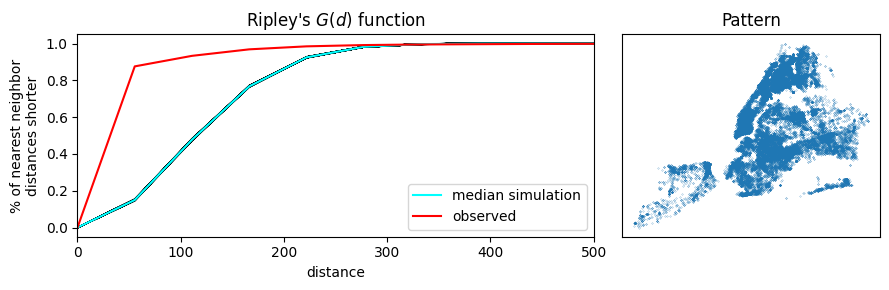

In [22]:
f,ax = plt.subplots(1,2,figsize=(9,3), 
                    gridspec_kw=dict(width_ratios=(6,3)))
# plot all the simulations with very fine lines
ax[0].plot(g_test.support, g_test.simulations.T, color='k', alpha=.01)
# and show the average of simulations
ax[0].plot(g_test.support, np.median(g_test.simulations, axis=0), color='cyan', 
         label='median simulation')


# and the observed pattern's G function
ax[0].plot(g_test.support, g_test.statistic, label = 'observed', color='red')

# clean up labels and axes
ax[0].set_xlabel('distance')
ax[0].set_ylabel('% of nearest neighbor\ndistances shorter')
ax[0].legend()
ax[0].set_xlim(0,500)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates_nyc.T,s=0.03)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title('Pattern')
f.tight_layout()
plt.show()


In [23]:
f_test = distance_statistics.f_test(
    coordinates_nyc, support=40, keep_simulations=True, n_simulations=999
)



In [24]:
print(f_test.support)
print(np.median(f_test.simulations,axis=0))

[   0.           55.46449063  110.92898126  166.3934719   221.85796253
  277.32245316  332.78694379  388.25143442  443.71592505  499.18041569
  554.64490632  610.10939695  665.57388758  721.03837821  776.50286885
  831.96735948  887.43185011  942.89634074  998.36083137 1053.82532201
 1109.28981264 1164.75430327 1220.2187939  1275.68328453 1331.14777516
 1386.6122658  1442.07675643 1497.54124706 1553.00573769 1608.47022832
 1663.93471896 1719.39920959 1774.86370022 1830.32819085 1885.79268148
 1941.25717212 1996.72166275 2052.18615338 2107.65064401 2163.11513464]
[0.    0.15  0.478 0.768 0.926 0.983 0.997 1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [25]:
#plt.plot(f_test.support, f_test.simulations.T, color='gray', alpha=0.1)

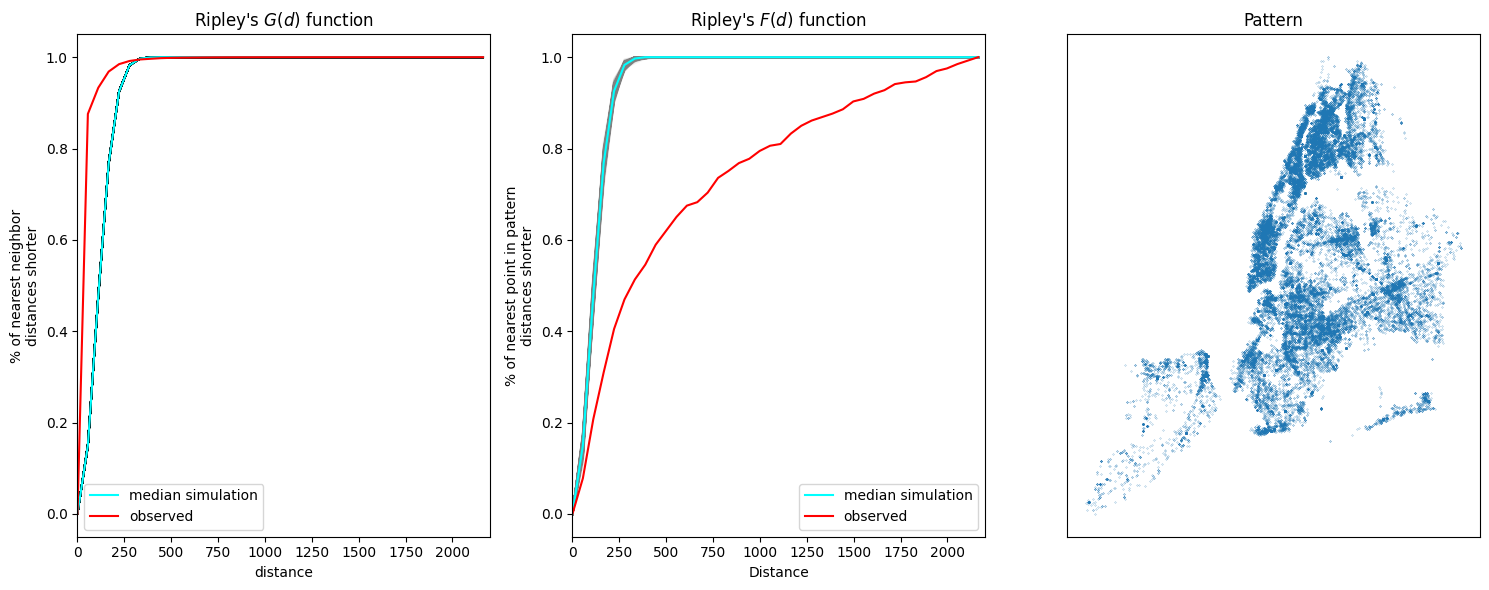

In [27]:
f, ax = plt.subplots(1, 3, figsize=(15, 6), gridspec_kw=dict(width_ratios=(6,6,6)))

# plot all the simulations with very fine lines
ax[0].plot(g_test.support, g_test.simulations.T, color='k', alpha=.01)
# and show the average of simulations
ax[0].plot(g_test.support, np.median(g_test.simulations, axis=0), color='cyan', 
         label='median simulation')


# and the observed pattern's G function
ax[0].plot(g_test.support, g_test.statistic, label = 'observed', color='red')

# clean up labels and axes
ax[0].set_xlabel('distance')
ax[0].set_ylabel('% of nearest neighbor\ndistances shorter')
ax[0].legend()
ax[0].set_xlim(0,2200)
ax[0].set_title(r"Ripley's $G(d)$ function")



# Plot all the simulations with very fine lines
ax[1].plot(f_test.support, f_test.simulations.T, color='gray', alpha=0.1)

# Plot the median of simulations
ax[1].plot(f_test.support, np.median(f_test.simulations, axis=0), color='cyan', label='median simulation')

# Plot the observed pattern's F function
ax[1].plot(f_test.support, f_test.statistic, label='observed', color='red')

# Clean up labels and axes
ax[1].set_xlabel('Distance')
ax[1].set_ylabel('% of nearest point in pattern\ndistances shorter')
ax[1].legend()
ax[1].set_xlim(0, 2200)
ax[1].set_title(r"Ripley's $F(d)$ function")

# Plot the pattern itself on the next frame
ax[2].scatter(*coordinates_nyc.T, s=0.03)

# Clean up labels and axes
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_title('Pattern')

f.tight_layout()
plt.show()


In [ ]:
import contextily as ctx

In [28]:


# Ensure geometry is set and CRS is correct
crimes = crimes.set_geometry("geometry")
crimes = crimes.to_crs("EPSG:4326")

# Group by the 'index' column and get the size of each group
grouped_princints = crimes.groupby("index").size().reset_index(name='size')

# Add unique geometries to the grouped DataFrame
unique_geo = crimes.drop_duplicates("index").set_index("index")["geometry"]

# Merge the grouped DataFrame with the unique geometries
grouped_princints = grouped_princints.merge(unique_geo, left_on="index", right_index=True)

# The grouped_princints DataFrame now has the 'size' and 'geometry' columns
grouped_princints_gdf = gpd.GeoDataFrame(grouped_princints,geometry = "geometry")
grouped_princints_gdf.head()


,index,size,geometry
0,0,801,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,1,750,"POLYGON ((-73.98864 40.72293, -73.98869 40.722..."
2,2,530,"POLYGON ((-74.00915 40.74251, -74.00895 40.742..."
3,3,587,"POLYGON ((-73.97346 40.71896, -73.97357 40.718..."
4,4,501,"POLYGON ((-73.97161 40.72672, -73.97163 40.726..."


In [29]:
from esda.moran import Moran

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
  warnings.warn(message)


k=1, Moran's I=0.09486310159113738, p-value=0.197
k=3, Moran's I=0.11370361504251293, p-value=0.076
k=4, Moran's I=0.11929450150318407, p-value=0.039
k=5, Moran's I=0.09524536211140044, p-value=0.05
k=6, Moran's I=0.07631634286560139, p-value=0.094
k=7, Moran's I=0.04929763642675348, p-value=0.127
k=8, Moran's I=0.06062874836968367, p-value=0.088
k=9, Moran's I=0.055672523681956396, p-value=0.081
k=10, Moran's I=0.06539055164362058, p-value=0.042
k=11, Moran's I=0.059838053614582914, p-value=0.051
k=12, Moran's I=0.04794381183652989, p-value=0.08
k=13, Moran's I=0.0517758964982523, p-value=0.056
k=14, Moran's I=0.05182678731378839, p-value=0.041
k=15, Moran's I=0.05068452705243057, p-value=0.045
Best k: 4 with Moran's I: 0.11929450150318407, p-value: 0.039


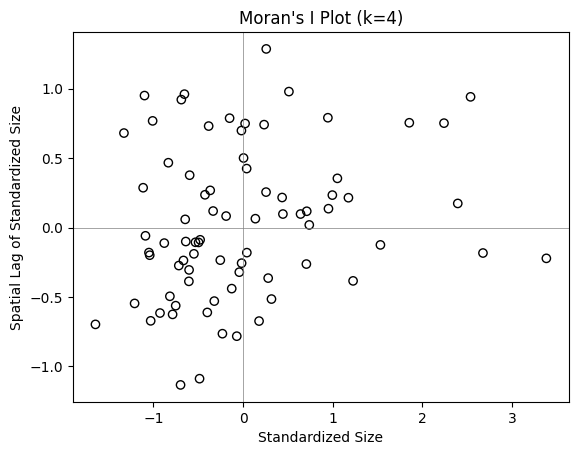

In [30]:

grouped_princints_gdf['size_standardized'] = (grouped_princints_gdf['size'] - grouped_princints_gdf['size'].mean()) / grouped_princints_gdf['size'].std()

k_values = [1, 3, 4, 5, 6,7, 8,9, 10,11,12,13,14,15]
best_k = None
best_moran = None

for k in k_values: 
    # Create KNN weights
    w_knn = weights.KNN.from_dataframe(grouped_princints_gdf, k=k)
    w_knn.transform = 'R'
    
    # Calculate Moran's I
    moran = Moran(grouped_princints_gdf['size_standardized'], w_knn)
    
    print(f"k={k}, Moran's I={moran.I}, p-value={moran.p_sim}")
    
    if best_moran is None or moran.I > best_moran.I:
        best_moran = moran
        best_k = k

print(f"Best k: {best_k} with Moran's I: {best_moran.I}, p-value: {best_moran.p_sim}")

# Moran's I plot for the best k
w_best = weights.KNN.from_dataframe(grouped_princints_gdf, k=best_k)
w_best.transform = 'R'
moran_best = Moran(grouped_princints_gdf['size_standardized'], w_best)

# Calculate the spatial lag manually
lagged_values = weights.spatial_lag.lag_spatial(w_best, grouped_princints_gdf['size_standardized'])

# Plotting Moran's I scatter plot
plt.scatter(grouped_princints_gdf['size_standardized'], lagged_values, edgecolor='k', facecolor='none')
plt.xlabel('Standardized Size')
plt.ylabel('Spatial Lag of Standardized Size')
plt.title(f"Moran's I Plot (k={best_k})")
plt.axvline(0, c='grey', lw=0.5)
plt.axhline(0, c='grey', lw=0.5)
plt.show()

In [31]:
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)

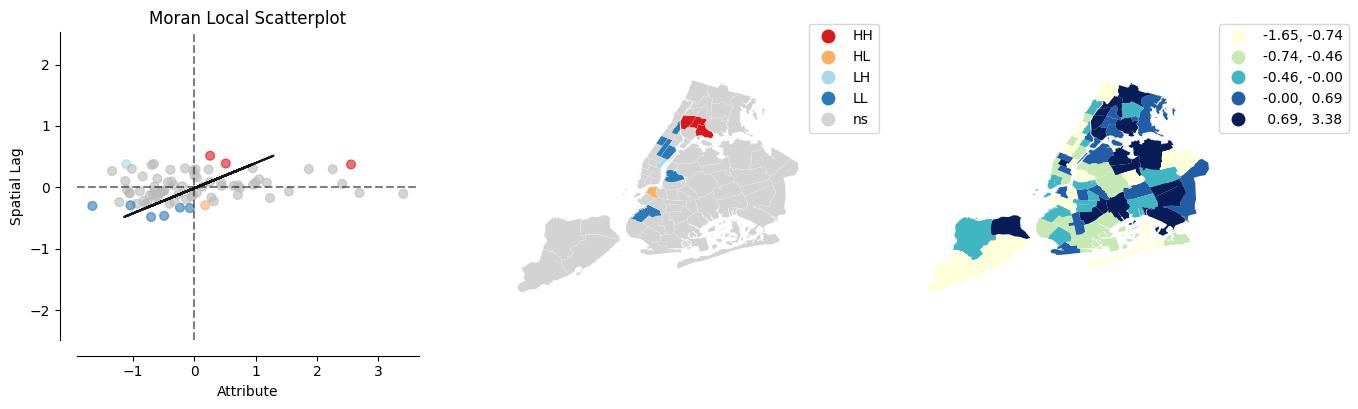

In [32]:
w_knn = weights.KNN.from_dataframe(grouped_princints_gdf, k=4)
w_knn.transform = 'R'


lisa = esda.Moran_Local(grouped_princints_gdf['size_standardized'], w_knn)
plot_local_autocorrelation(lisa, grouped_princints_gdf, 'size_standardized');

Indices of High-High areas: Int64Index([23, 24, 26], dtype='int64')


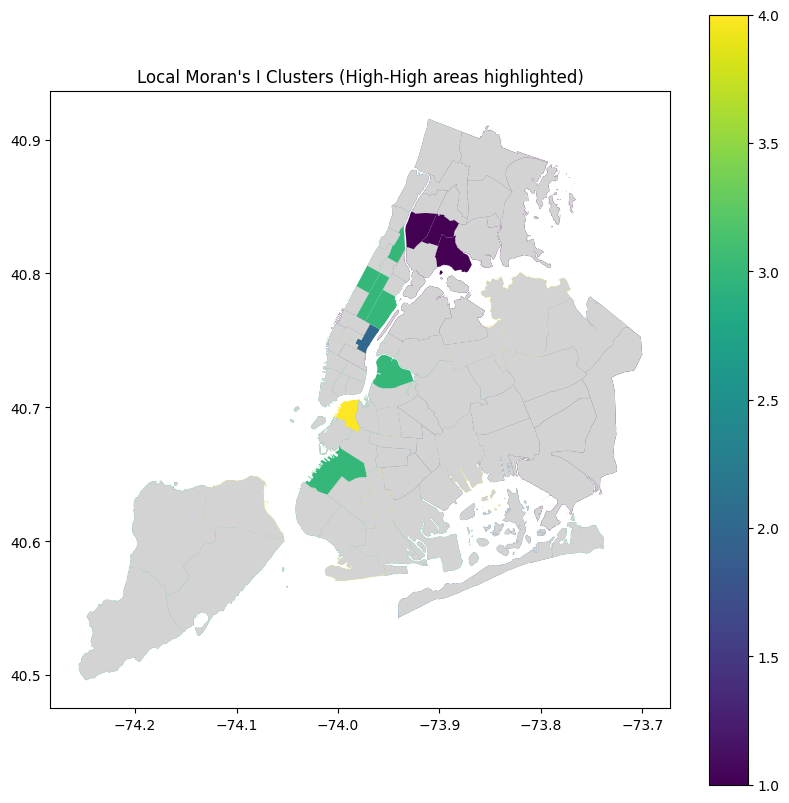

In [33]:
#Define significance threshold
significance_threshold = 0.05

# Identify High-High (HH) clusters
hh_clusters = (lisa.q == 1) & (lisa.p_sim < significance_threshold)

# Extract indices of High-High areas
hh_indices = grouped_princints_gdf[hh_clusters].index

# Print the indices of High-High areas
print("Indices of High-High areas:", hh_indices)

# Optionally, plot the results
grouped_princints_gdf['lisa_cluster'] = lisa.q
grouped_princints_gdf['significant'] = lisa.p_sim < significance_threshold

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grouped_princints_gdf.plot(column='lisa_cluster', cmap='viridis', legend=True, ax=ax)
grouped_princints_gdf[~grouped_princints_gdf['significant']].plot(color='lightgrey', ax=ax)
plt.title('Local Moran\'s I Clusters (High-High areas highlighted)')
plt.show()

# Note to the Moran I. 
- 1) We took k = 4 since that gave the lowest p-value of threshold 0.046. The I statistic ended at I=0.1145687316947015, Weakly clustered. 
- 2) This follows the upper area of high density of the KDE plot
- 3) The high-high (HH) are the Precints are ["41st Precint", "42nd Precint" and "44th Precint"]

In [34]:
from collections import Counter

In [35]:
### Should be 3 Level of Offense Felony, Misdemeanor, Violation

merged_gdf_new["law_cat_cd"]
list(set(merged_gdf_new["law_cat_cd"].values))

['F', 'M']

In [36]:
merged_gdf_new


,index,index_left,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,...,y_coord_cd,latitude,longitude,geocoded_column,precinct,shape_area,shape_leng,geometry,x,y
0,0,53869,280981409,2024-01-23T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,194782,40.701310,-74.014570,POINT (-74.01457 40.70131),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239264e+06,4.968384e+06
1,0,45583,281029902,2024-01-24T00:00:00.000,511.0,"CONTROLLED SUBSTANCE, POSSESSI",235.0,DANGEROUS DRUGS,PL 2200300,M,...,194854,40.701505,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06
2,0,28122,283104116,2024-03-03T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,194854,40.701505,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06
4,0,24709,282805064,2024-02-26T00:00:00.000,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,...,194854,40.701505,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06
5,0,773,284365468,2024-03-26T00:00:00.000,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 140100G,M,...,194854,40.701505,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63610,76,31029,282397465,2024-02-18T00:00:00.000,793.0,WEAPONS POSSESSION 3,118.0,DANGEROUS WEAPONS,PL 2650201,F,...,144013,40.561813,-74.182656,POINT (-74.18266 40.56181),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.257976e+06,4.947922e+06
63611,76,46462,282408151,2024-02-18T00:00:00.000,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601002,F,...,144153,40.562204,-74.179569,POINT (-74.17957 40.56220),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.257632e+06,4.947980e+06
63612,76,22541,283309464,2024-03-06T00:00:00.000,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,...,144362,40.562769,-74.183925,POINT (-74.18393 40.56277),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.258117e+06,4.948063e+06
63613,76,32122,283312461,2024-03-06T00:00:00.000,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,...,144362,40.562769,-74.183925,POINT (-74.18393 40.56277),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.258117e+06,4.948063e+06


In [37]:
laws_violation_type = merged_gdf_new["law_cat_cd"]
print(Counter(laws_violation_type.values))


#print(len(list(ofsn["law_cat_cd"].values)))
#type = ofsn[ofsn["law_cat_cd"]=="9"]
#type

Counter({'M': 35575, 'F': 26652})


### Notes to law_cat_cd
- 1) There is 5 Variables ("F": Felony", "V": "Violation","M":misdemeanor, "I", Infraction": "9": "Adminstrative Violation", "nan": "nan", "(none)": "None") law_cat_cd
- 2) There are 411 "nan" values. All of them are with ofsn_desc "FOR OTHER AUTHORITIES" or "(None)". 2 "(None)" in law_cat_cd
- 3) 507 People are ofsn_desc "OTHER STATE LAWS"
- 4) We have Counter({'M': 35575, 'F': 26652, 'V': 775, nan: 402, '9': 155, 'I': 54, '(null)': 2})
- 5) Type of Crimes
    - 5.1) The punishment for traffic violations is not considered a criminal punishment.
    - 5.2) A misdemeanor is the lowest level of crime
    - 5.3) Felonies are the most serious types of crimes
    - 5.4) A violation is any non-criminal offense, other than traffic infractions.

<Axes: >

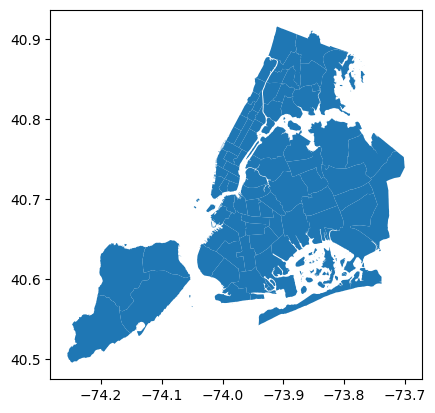

In [38]:
Police_Precints.plot()

In [42]:
#demographics_PP

P1_001N    8804081
P1_002N    7917026
P1_003N    3000916
P1_004N    1943634
P1_005N      86217
P1_006N    1385140
P1_007N       6873
P1_008N    1494246
dtype: int64
Diff:  887055
103
[1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 83, 84, 88, 90, 94, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123]


In [110]:
merged_gdf_new.head()

,index,index_left,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,...,longitude,geocoded_column,precinct,shape_area,shape_leng,geometry,x,y,borough,precinct_number
0,0,53869,280981409,2024-01-23T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,-74.014570,POINT (-74.01457 40.70131),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239264e+06,4.968384e+06,Manhattan,1
1,0,45583,281029902,2024-01-24T00:00:00.000,511.0,"CONTROLLED SUBSTANCE, POSSESSI",235.0,DANGEROUS DRUGS,PL 2200300,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
2,0,28122,283104116,2024-03-03T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
4,0,24709,282805064,2024-02-26T00:00:00.000,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
5,0,773,284365468,2024-03-26T00:00:00.000,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 140100G,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1


In [55]:
print(list(demographics_PP["precinct"].values))

precinct_dict = {"Manhattan": 
                 {"1st Precinct": 1, 
                "5th Precinct": 5,
                "6th Precinct": 6,
                "7th Precinct": 7,
                "9th Precinct": 9,
                "10th Precinct": 10,
                "13th Precinct": 13,
                "Midtown South Precinct": 14,
                "17th Precinct": 17,
                "Midtown North Precinct": 18,
                "19th Precinct": 19,
                "20th Precinct": 20,
                "Central Park Precint": 22,
                "23rd Precinct": 23, 
                "24th Precinct": 24,
                "25th Precinct": 25, 
                "26th Precinct": 26,
                "28th Precinct": 28,
                "30th Precinct": 30,
                "32nd Precinct": 32,
                "33rd Precinct": 33,
                "34th Precinct": 34},
                "Bronx": {
                "40th Precinct": 40,
                "41st Precinct": 41,
                "42nd Precinct": 42,
                "43rd Precinct": 43,
                "44th Precinct": 44,
                "45th Precinct": 45,
                "46th Precinct": 46,
                "47th Precinct": 47,
                "48th Precinct": 48,
                "49th Precinct": 49,
                "50th Precinct": 50,
                "52nd Precinct": 52},
                "Brooklyn": {
                "60th Precint": 60,
                "61st Precinct": 61, 
                "62nd Precinct": 62,
                "63rd Precinct": 63,
                "66th Precinct": 66,
                "67th Precinct": 67,
                "68th Precinct": 68,
                "69th Precinct": 69,
                "70th Precinct": 70,
                "71st Precinct": 71,
                "72nd Precinct": 72,
                "73rd Precinct": 73,
                "75th Precinct": 75,
                "76th Precinct": 76,
                "77th Precinct": 77,
                "78th Precinct": 78,
                "79th Precinct": 79,
                "81st Precinct": 81,
                "83rd Precinct": 83,
                "84th Precinct": 84,
                "88th Precinct": 88,
                "90th Precint": 90,
                "94th Precinct": 94},
                "Queens":{
                "100th Precinct": 100,
                "101st Precinct": 101,
                "102nd Precint": 102,
                "103rd Precinct": 103,
                "104th Precinct": 104,
                "105th Precinct": 105,
                "106th Precinct": 106,
                "107th Precinct": 107,
                "108th Precinct": 108,
                "109th Precinct": 109,
                "110th Precinct": 110, 
                "111th Precinct": 111,
                "112th Precinct": 112,
                "113th Precinct": 113,
                "114th Precinct": 114,
                "115th Precinct": 115,
                "120th Precinct": 120,
                "121st Precinct": 121,
                "122nd Precinct": 122,
                "123rd Precinct": 123}
}


[1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 83, 84, 88, 90, 94, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123]


In [68]:
# Flatten the precinct_dict to get a list of precincts in the order of indices
precinct_list = []
for borough, precincts in precinct_dict.items():
    for precinct_name, precinct_number in precincts.items():
        precinct_list.append((borough, precinct_number))

# Ensure the list has exactly 77 entries (indices 0 to 76)
assert len(precinct_list) == 77, "The precinct list length should be 77"

# Create a DataFrame from the precinct list
precinct_df = pd.DataFrame(precinct_list, columns=['borough', 'precinct_number'])

# Merge the precinct information with merged_gdf_new
merged_gdf_new['borough'] = merged_gdf_new['index'].map(lambda x: precinct_df.iloc[x]['borough'])
merged_gdf_new['precinct_number'] = merged_gdf_new['index'].map(lambda x: precinct_df.iloc[x]['precinct_number'])

# Display the updated DataFrame
#merged_gdf_new

In [69]:
merged_gdf_new

,index,index_left,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,...,longitude,geocoded_column,precinct,shape_area,shape_leng,geometry,x,y,borough,precinct_number
0,0,53869,280981409,2024-01-23T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,-74.014570,POINT (-74.01457 40.70131),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239264e+06,4.968384e+06,Manhattan,1
1,0,45583,281029902,2024-01-24T00:00:00.000,511.0,"CONTROLLED SUBSTANCE, POSSESSI",235.0,DANGEROUS DRUGS,PL 2200300,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
2,0,28122,283104116,2024-03-03T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
4,0,24709,282805064,2024-02-26T00:00:00.000,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
5,0,773,284365468,2024-03-26T00:00:00.000,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 140100G,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63610,76,31029,282397465,2024-02-18T00:00:00.000,793.0,WEAPONS POSSESSION 3,118.0,DANGEROUS WEAPONS,PL 2650201,F,...,-74.182656,POINT (-74.18266 40.56181),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.257976e+06,4.947922e+06,Queens,123
63611,76,46462,282408151,2024-02-18T00:00:00.000,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601002,F,...,-74.179569,POINT (-74.17957 40.56220),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.257632e+06,4.947980e+06,Queens,123
63612,76,22541,283309464,2024-03-06T00:00:00.000,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,...,-74.183925,POINT (-74.18393 40.56277),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.258117e+06,4.948063e+06,Queens,123
63613,76,32122,283312461,2024-03-06T00:00:00.000,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,...,-74.183925,POINT (-74.18393 40.56277),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.258117e+06,4.948063e+06,Queens,123


In [89]:
#race_nyc = nyc[["european","asian","hispanic","american", "african", "mixed", "pacific", "otherethni", "boroname"]]

nyc_data = examples.load_example("NYC Socio-Demographics")
nyc = gpd.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))


unique_boro_names = list(set(nyc["boroname"].values))


In [96]:
from shapely.ops import unary_union

In [106]:
#List of columns to sum

Manhattan = nyc[nyc["boroname"] == "Manhattan"]




Brooklyn = nyc[nyc["boroname"] == "Brooklyn"]
Bronx = nyc[nyc["boroname"] == "Bronx"]
Queens = nyc[nyc["boroname"] == "Queens"]
Staten_Island = nyc[nyc["boroname"] == "Staten Island"]

def all_boroughts(df):
    sum_columns = [
        'withssi', 'withsocial', 'withpubass', 'struggling', 'profession', 'popunemplo', 
        'poptot', 'popover18', 'popinlabou', 'poororstru', 'poor', 'pacificune', 
        'pacificinl', 'pacific', 'otherunemp', 'otherinlab', 'otherethni', 'onlyprofes', 
        'onlymaster', 'onlylessth', 'onlyhighsc', 'onlydoctor', 'onlycolleg', 'onlybachel', 
        'okay', 'mixedunemp', 'mixedinlab', 'mixed', 'master', 'maleunempl', 'maleover18', 
        'malepro', 'malemastr', 'male_lesHS', 'male_HS', 'male_doctr', 'male_collg', 'male_BA', 
        'maleinlabo', 'maledrop', 'male16to19', 'male', 'lessthanhi', 'lessthan10', 'households', 
        'hispanicun', 'hispanicin', 'hispanic', 'highschool', 'femaleunem', 'femaleover', 'fem_profes', 
        'fem_master', 'fem_lessHS', 'fem_HS', 'fem_doctor', 'fem_colleg', 'fem_BA', 'femaleinla', 
        'femaledrop', 'femal16_19', 'female', 'europeanun', 'europeanin', 'european', 'doctorate', 
        'com_90plus', 'comm_5less', 'comm_60_89', 'comm_5_14', 'comm_45_59', 'comm_30_44', 'comm_15_29', 
        'college', 'bachelor', 'asianunemp', 'asianinlab', 'asian', 'americanun', 'americanin', 
        'american', 'africanune', 'africaninl', 'african'
    ]

    # List of columns to average
    mean_columns = [
        'UNEMP_RATE', 'medianinco', 'medianagem', 'medianagef', 'medianage', 'gini'
    ]

    # Drop columns that are not needed for aggregation
    drop_columns = [
        'cartodb_id', 'geo_state', 'geo_place', 'geo_county', 'field_1', 'puma', 
        'ntaname', 'ntacode', 'ctlabel', 'cdeligibil', 'boroname', 'geo_stusab', 
        'geo_name', 'geo_geoid', 'shape_leng', 'shape_area', 'ct2010', 'boroct2010', 
        'borocode', 'tractid', 'popdty', 'geo_fips'
    ]

    # Aggregate the columns
    aggregated_data = pd.DataFrame()

    # Sum columns
    if sum_columns:
        sum_data = df[sum_columns].sum().to_frame().T
        aggregated_data = pd.concat([aggregated_data, sum_data], axis=1)

    # Mean columns
    if mean_columns:
        mean_data = df[mean_columns].mean().to_frame().T
        aggregated_data = pd.concat([aggregated_data, mean_data], axis=1)

    # Merge geometries
    merged_geometry = unary_union(df.geometry)

    # Create a new GeoDataFrame with the aggregated data and merged geometry
    summed_df= gpd.GeoDataFrame(aggregated_data, geometry=[merged_geometry], crs=Manhattan.crs)

    # Display the resulting GeoDataFrame
    return summed_df


Manhattan_summed = all_boroughts(Manhattan)
Brooklyn_summed = all_boroughts(Brooklyn)
Bronx_summed = all_boroughts(Bronx)
Queens_summed = all_boroughts(Queens)
Staten_Island_summed = all_boroughts(Staten_Island)

C:\Users\User\AppData\Local\Temp\ipykernel_14608\3683773510.py:53: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_data = df[mean_columns].mean().to_frame().T
C:\Users\User\AppData\Local\Temp\ipykernel_14608\3683773510.py:53: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_data = df[mean_columns].mean().to_frame().T
C:\Users\User\AppData\Local\Temp\ipykernel_14608\3683773510.py:53: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, spe

In [108]:
merged_gdf_new

,index,index_left,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,...,longitude,geocoded_column,precinct,shape_area,shape_leng,geometry,x,y,borough,precinct_number
0,0,53869,280981409,2024-01-23T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,-74.014570,POINT (-74.01457 40.70131),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239264e+06,4.968384e+06,Manhattan,1
1,0,45583,281029902,2024-01-24T00:00:00.000,511.0,"CONTROLLED SUBSTANCE, POSSESSI",235.0,DANGEROUS DRUGS,PL 2200300,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
2,0,28122,283104116,2024-03-03T00:00:00.000,258.0,"CRIMINAL MISCHIEF 4TH, GRAFFIT",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1456002,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
4,0,24709,282805064,2024-02-26T00:00:00.000,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
5,0,773,284365468,2024-03-26T00:00:00.000,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 140100G,M,...,-74.012551,POINT (-74.01255 40.70151),1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-8.239039e+06,4.968413e+06,Manhattan,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63610,76,31029,282397465,2024-02-18T00:00:00.000,793.0,WEAPONS POSSESSION 3,118.0,DANGEROUS WEAPONS,PL 2650201,F,...,-74.182656,POINT (-74.18266 40.56181),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.257976e+06,4.947922e+06,Queens,123
63611,76,46462,282408151,2024-02-18T00:00:00.000,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601002,F,...,-74.179569,POINT (-74.17957 40.56220),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.257632e+06,4.947980e+06,Queens,123
63612,76,22541,283309464,2024-03-06T00:00:00.000,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,...,-74.183925,POINT (-74.18393 40.56277),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.258117e+06,4.948063e+06,Queens,123
63613,76,32122,283312461,2024-03-06T00:00:00.000,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,...,-74.183925,POINT (-74.18393 40.56277),123.0,4.608610e+08,120806.625007,"POLYGON ((-74.16983 40.56109, -74.16983 40.560...",-8.258117e+06,4.948063e+06,Queens,123


In [48]:
#demographics_PP_selcted = demographics_PP[["precinct", "P1_001N", "P1_002N", "P1_003N", "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]]

#Police_Pricints["precinct"] = pd.to_numeric(Police_Pricints["precinct"], downcast='integer')
#Police_Pricints["precinct"]
#demographics_PP["precinct"].values

#combined = pd.merge(Police_Pricints, demographics_PP_selcted, on="precinct", how="inner")

# Display the resulting DataFrame
#combined


,precinct,shape_area,shape_leng,geometry,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,1,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",84799,76937,57501,2655,96,14624,55,2006
1,5,1.809453e+07,18807.124911,"POLYGON ((-73.98864 40.72293, -73.98869 40.722...",50598,47663,13363,3556,109,27507,69,3059
2,6,2.214302e+07,27255.991120,"POLYGON ((-74.00915 40.74251, -74.00895 40.742...",64643,59481,50320,1782,72,5635,34,1638
3,7,1.836667e+07,17287.544493,"POLYGON ((-73.97346 40.71896, -73.97357 40.718...",57985,51746,18416,6934,396,17779,46,8175
4,9,2.139539e+07,19772.510741,"POLYGON ((-73.97161 40.72672, -73.97163 40.726...",75951,68112,41843,6610,480,11322,84,7773
...,...,...,...,...,...,...,...,...,...,...,...,...
72,115,1.141197e+08,60059.410758,"POLYGON ((-73.85892 40.76241, -73.85931 40.762...",179134,154691,26261,10054,4894,34726,119,78637
73,120,2.323280e+08,92945.697403,"POLYGON ((-74.05357 40.60370, -74.05407 40.603...",122308,109715,46574,28782,1410,14002,63,18884
74,121,4.755776e+08,136811.464647,"MULTIPOLYGON (((-74.15946 40.64145, -74.15975 ...",128149,117516,61832,17664,1517,19670,71,16762
75,122,4.548521e+08,154842.385071,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",144552,135413,104075,4494,464,18771,66,7543


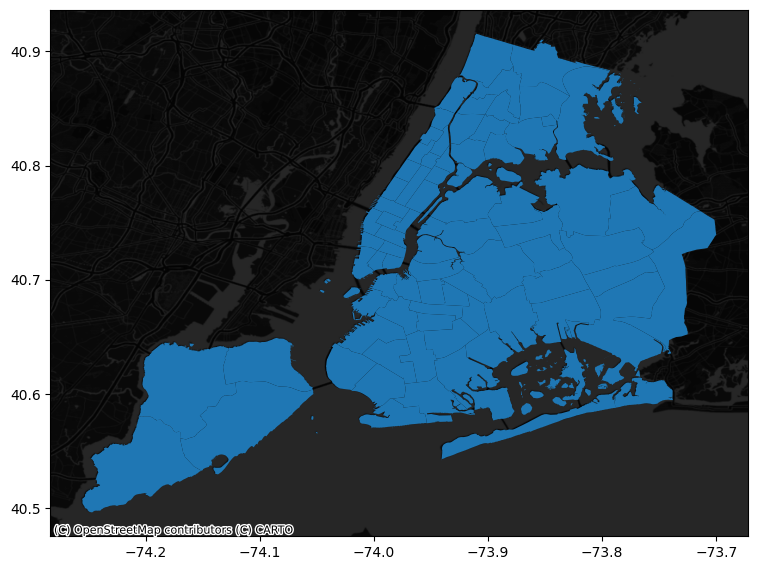

In [411]:
#Police_Pricints.plot()
ax = Police_Pricints.plot(figsize=(9, 9))
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

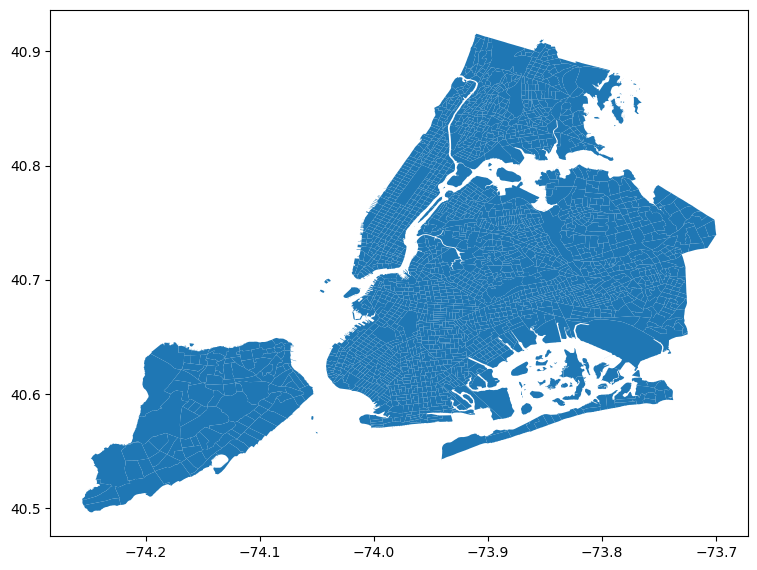

In [44]:
# Load data
nyc_data = examples.load_example("NYC Socio-Demographics")

nyc = gpd.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))

nyc.plot(figsize=(9, 9));

In [408]:



#print(nyc.crs)
demographics_within_PP = gpd.sjoin(nyc, Police_Pricints, how='right', predicate='within')
demographics_within_PP_new = demographics_within_PP.reset_index()
demographics_within_PP_new
# Group by "index" and aggregate using first for the geometry column
summed_demo_PP_with_geometry = demographics_within_PP_new.groupby("index").agg(
    european=("european", "sum"),
    asian=("asian", "sum"),
    hispanic=("hispanic", "sum"),
    american=("american", "sum"),
    african=("african", "sum"),
    mixed=("mixed", "sum"),
    pacific=("pacific", "sum"),
    otherethni=("otherethni", "sum"),
    boroname=("boroname", "first"),
    male=("male", "sum"),
    female=("female", "sum"),
    geometry=("geometry", "first")
).reset_index()

# Display the resulting DataFrame
#summed_demo_PP_with_geometry
print("Start: ",np.sum(nyc[["female","male"]].values))
print("NYC grouped Precints",np.sum(summed_demo_PP_with_geometry[["male", "female"]].values))


Start:  8199221
NYC grouped Precints 4151206.0


In [402]:
np.sum(summed_demo_PP_with_geometry[["male", "female"]].values)

4151206.0

In [407]:
np.sum(nyc[["female","male"]].values)

8199221

### Start Looking at Specific Crimes

In [13]:
ofns_desc = merged_gdf.groupby("ofns_desc")
ofns_desc_counts_per_princint = ofns_desc["ofns_desc"].value_counts()
ofns_desc_counts_per_princint.sort_values(ascending = False).head(40)

ofns_desc                        ofns_desc                      
ASSAULT 3 & RELATED OFFENSES     ASSAULT 3 & RELATED OFFENSES       8959
PETIT LARCENY                    PETIT LARCENY                      6526
FELONY ASSAULT                   FELONY ASSAULT                     5287
DANGEROUS DRUGS                  DANGEROUS DRUGS                    4733
MISCELLANEOUS PENAL LAW          MISCELLANEOUS PENAL LAW            3992
VEHICLE AND TRAFFIC LAWS         VEHICLE AND TRAFFIC LAWS           3921
GRAND LARCENY                    GRAND LARCENY                      3068
ROBBERY                          ROBBERY                            2945
CRIMINAL MISCHIEF & RELATED OF   CRIMINAL MISCHIEF & RELATED OF     2817
DANGEROUS WEAPONS                DANGEROUS WEAPONS                  2509
OTHER OFFENSES RELATED TO THEF   OTHER OFFENSES RELATED TO THEF     2227
OFFENSES AGAINST PUBLIC ADMINI   OFFENSES AGAINST PUBLIC ADMINI     1981
BURGLARY                         BURGLARY                  

In [14]:
#print(merged_gdf.columns)
grouped = merged_gdf.groupby("index")
grouped_crime_group = grouped["ofns_desc"].value_counts()


counts_by_group_agg = grouped["ofns_desc"].agg(lambda x: x.value_counts().to_dict())

# Print the aggregated counts
Princint_DANGEROUS_DRUGS = {}
for count, crimes_counts in enumerate(counts_by_group_agg):
    try:
        Princint_DANGEROUS_DRUGS[count] = crimes_counts["DANGEROUS DRUGS"]
        count+=1
    except: 
        Princint_DANGEROUS_DRUGS[count] = 0

In [15]:
Princint_DANGEROUS_DRUGS

{0: 14,
 1: 67,
 2: 85,
 3: 51,
 4: 29,
 5: 55,
 6: 16,
 7: 261,
 8: 10,
 9: 44,
 10: 5,
 11: 2,
 12: 0,
 13: 51,
 14: 24,
 15: 292,
 16: 9,
 17: 64,
 18: 56,
 19: 47,
 20: 79,
 21: 100,
 22: 193,
 23: 40,
 24: 56,
 25: 50,
 26: 119,
 27: 21,
 28: 165,
 29: 48,
 30: 65,
 31: 29,
 32: 6,
 33: 153,
 34: 100,
 35: 44,
 36: 41,
 37: 10,
 38: 35,
 39: 37,
 40: 33,
 41: 31,
 42: 76,
 43: 74,
 44: 88,
 45: 120,
 46: 165,
 47: 29,
 48: 42,
 49: 29,
 50: 108,
 51: 59,
 52: 70,
 53: 32,
 54: 22,
 55: 42,
 56: 23,
 57: 20,
 58: 35,
 59: 47,
 60: 309,
 61: 14,
 62: 22,
 63: 34,
 64: 20,
 65: 4,
 66: 47,
 67: 54,
 68: 5,
 69: 6,
 70: 77,
 71: 65,
 72: 79,
 73: 203,
 74: 43,
 75: 19,
 76: 14}

In [16]:
grouped_crime_group

index  ofns_desc                     
0      PETIT LARCENY                     256
       GRAND LARCENY                     111
       ASSAULT 3 & RELATED OFFENSES       69
       CRIMINAL MISCHIEF & RELATED OF     55
       BURGLARY                           36
                                        ... 
76     ENDAN WELFARE INCOMP                1
       FOR OTHER AUTHORITIES               1
       INTOXICATED/IMPAIRED DRIVING        1
       MURDER & NON-NEGL. MANSLAUGHTE      1
       OTHER STATE LAWS (NON PENAL LA      1
Name: ofns_desc, Length: 2701, dtype: int64

In [18]:
import shapely.geometry as geom

In [19]:

dd = merged_gdf[merged_gdf["ofns_desc"] == "DANGEROUS DRUGS"]
new_dd = dd.copy()
dd['geocoded_column'] = [geom.Point(xy) for xy in zip(dd['longitude'], dd['latitude'])]
print(dd['geocoded_column'].isnull().sum())
dd = dd.set_geometry('geocoded_column')

0


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [166]:
### Important we use Block for weights. We are focused at Adminstrative Boundaries 
### Could argue for Queen, Bishop as well but they are more flow related. 

#w_knn = weights.KNN.from_dataframe(dd, k=10)
#mx_bw = weights.util.block_weights(dd["index"].values, list(dd.index))
#mx_union = weights.set_operations.w_union(w_knn, mx_bw)
#ax = new_dd.plot(column="ofns_desc", categorical=True, cmap="Pastel2")

#mx_union.plot(ax=ax,gdf=new_dd, edge_kws=dict(linewidth=1, color="orangered"), node_kws=dict(marker="*"))

# Plot spatial weights
#w_knn.plot(ax=ax, gdf=dd, edge_kws=dict(linewidth=1, color="blue"), node_kws=dict(marker="o", color="blue"))

# Customize plot
#ax.set_axis_off()
#ax.set_title("Block and Spatial Weights")

# Show plot
#plt.show()

In [ ]:
### Need a  bit more work 
#lisa = esda.moran.Moran_Local(db["Pct_Leave"], w)

In [2]:
## Takes 1 Min to run
#plot_spatial_weights(w, dd.to_crs(epsg=27700), indexed_on="index_left");

w

In [3]:
#dd['w_DANGEROUS_DRUGS_ofns_desc'] = weights.lag_spatial(w, dd['ofns_desc'])